In [2]:
from bbq.decoder import d_osd, bp_osd
import numpy as np
from ldpc import BpDecoder, bposd_decoder
from bbq.polynomial import Polynomial
from bbq.bbq_code import BivariateBicycle
import matplotlib.pyplot as plt
import json
import datetime

## Simple examples

In [79]:
h_eff = np.array([[0, 0, 1, 1], [0, 1, 1, 1], [0, 1, 1, 0]])
prior = np.array([[0.9, 0.1], [0.9, 0.1], [0.8, 0.2], [0.8, 0.2]])

p = 0.1
field = 2
max_iter = 1000

n_dets, n_qudits = h_eff.shape
real_error = np.zeros(n_qudits, dtype=int)
rand = np.random.rand(n_qudits)
for err in range(n_qudits):
    if rand[err] < prior[err, 1]:
        real_error[err] = 1
syndrome = (h_eff @ real_error) % field

print(f'h_eff = \n {h_eff}')
print(f'prior = \n {prior}')
print(f'real_error = \n {real_error}')
print(f'syndrome = \n {syndrome}')

h_eff = 
 [[0 0 1 1]
 [0 1 1 1]
 [0 1 1 0]]
prior = 
 [[0.9 0.1]
 [0.9 0.1]
 [0.8 0.2]
 [0.8 0.2]]
real_error = 
 [0 0 1 0]
syndrome = 
 [1 1 1]


In [80]:
error, success = d_osd(field, h_eff, syndrome, prior, debug=False)

assert success
assert (error == real_error).all()

In [188]:
error, success, bp_success, posterior = bp_osd(field, h_eff, syndrome, prior, max_iter=1, debug=True)

assert success
(error == real_error).all()

np.True_

In [189]:
posterior[:, 1]

array([ 0.        ,  0.94444444, 25.61538462,  2.84615385])

In [190]:
np.log(1/posterior[:, 1])

C:\Users\elean\AppData\Local\Temp\ipykernel_39300\1214461436.py:1: RuntimeWarning: divide by zero encountered in divide
  np.log(1/posterior[:, 1])


array([        inf,  0.05715841, -3.24319313, -1.04596856])

In [191]:
error

array([0, 0, 1, 0], dtype=uint8)

In [192]:
bpd = BpDecoder(h_eff, error_channel=prior[:, 1], max_iter=1, bp_method='product_sum')
error = bpd.decode(syndrome)

(error == real_error).all()

np.False_

In [193]:
bpd.log_prob_ratios

array([ 2.19722458,  0.05715841, -3.24319313, -1.04596856])

In [194]:
bpd.decoding

array([0, 0, 1, 1])

In [153]:
g = bpd.log_prob_ratios
1/np.exp(g)

array([ 0.11111111,  0.94444444, 25.61538462,  2.84615385])

## Fixing OSD

In [ ]:
# Code capacity model for qubit Toric code with varying distance

a = Polynomial(2, np.array([[1, 0], [1, 0]]))
b = Polynomial(2, np.array([[1, 1], [0, 0]]))

num_failures = 5
max_iter = 1000
results_debug_osd = {}

save_data = {}
save_data_filename = f'data_{datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")}.json'

bp_errors = 0
osd_errors = 0

bp_success = 0
osd_success = 0

failed_osd_posteriors = []
successful_osd_posteriors = []

for d in [5]:
    bb = BivariateBicycle(a, b, d, d, 1)
    lx = bb.x_logicals
    # res = results_cap_qubit[d]
    res = []
    # for ind, p in enumerate(np.logspace(-3, -1, 10)):
    for p in [0.01]:
        failures = 0
        num_trials = 0
        #if d == 5:
        #    if p < 0.002:
        #        res.append(np.inf)
        #        continue
        #if d == 7:
        #    if p < 0.003:
        #        res.append(np.inf)
        #        continue
        #if d == 9:
        #    if p < 0.004:
        #        res.append(np.inf)
        #        continue
        while failures < num_failures:
            # Generate syndrome
            n_qudits = bb.hx.shape[1]
            error = np.zeros(n_qudits, dtype=int)
            error_mask = np.random.rand(n_qudits) < p
            for i in np.where(error_mask)[0]:
                error[i] = np.random.randint(1, bb.field)
            syndrome = (bb.hx @ error) % bb.field

            # Construct error probability
            channel_prob_x = np.ones(n_qudits) * p

            x_prior = np.zeros((len(channel_prob_x), 2), dtype=float)

            for i, prob in enumerate(channel_prob_x):
                x_prior[i, 0] = 1 - prob
                for j in range(1, 2):
                    x_prior[i, j] = prob / (2 - 1)

            # Decode
            guessed_error, decoder_success, bp_success, posterior = bp_osd(bb.field, bb.hx, syndrome, x_prior, max_iter, order=0, debug=True)
            error_difference = (error - guessed_error) % 2
            logical_effect = (np.array(lx) @ error_difference) % 2

            # Check success
            if np.any(logical_effect != 0):
                failures += 1
                if bp_success:
                    bp_errors += 1
                else:
                    osd_errors += 1
                    failed_osd_posteriors.append(posterior)
                print(f'Found {failures} / {num_failures}, with num_trials : {num_trials}')
            else:
                if bp_success:
                    bp_success += 1
                else:
                    osd_success += 1
                    successful_osd_posteriors.append(posterior)

            if num_trials % 100 == 0:
                save_data['num_trials'] = num_trials
                save_data['failures'] = failures
                json.dump(save_data, open(save_data_filename, 'w'), indent=4)
        
            num_trials += 1
        # res[1+ind] = num_trials
        res.append(num_trials)
        print(f'Finished p={p} for d={d} with num_trials={num_trials}')
    print(f'Completed d={d}')
    results_debug_osd[d] = res

C:\Users\elean\Documents\Quantum-Computing-PhD\ITP\IP-BBQ\qudit-bivariate-bicycle\bbq\decoder.py:76: ComplexWarning: Casting complex values to real discards the imaginary part
  P[i, error, k] = sub_convolution[(syndrome[i] - k) % field]


Found 1 / 5, with num_trials : 121
Found 2 / 5, with num_trials : 129


KeyboardInterrupt: 

In [222]:
2/3600

0.0005555555555555556

In [223]:
bp_errors

1

In [224]:
osd_errors

1

In [239]:
bp_success

2

In [240]:
osd_success

51

In [237]:
failed_osd_posteriors

[array([[2.05857276e+00, 4.85773453e-01],
        [5.31720259e-01, 1.88068817e+00],
        [4.38763701e+02, 2.27913111e-03],
        [8.63736726e+05, 1.15776019e-06],
        [2.17051943e+04, 4.60719211e-05],
        [2.21205749e+02, 4.52067816e-03],
        [8.84209883e+01, 1.13095320e-02],
        [4.47590237e+02, 2.23418636e-03],
        [2.08425231e+06, 4.79788362e-07],
        [8.41494443e+05, 1.18836198e-06],
        [2.22276900e+02, 4.49889305e-03],
        [2.22276900e+02, 4.49889305e-03],
        [5.40744576e+05, 1.84930195e-06],
        [4.62390761e+07, 2.16267297e-08],
        [5.40744576e+05, 1.84930195e-06],
        [8.84209883e+01, 1.13095320e-02],
        [2.21205749e+02, 4.52067816e-03],
        [8.41494443e+05, 1.18836198e-06],
        [2.08425231e+06, 4.79788362e-07],
        [4.47590237e+02, 2.23418636e-03],
        [5.31720259e-01, 1.88068817e+00],
        [2.05857276e+00, 4.85773453e-01],
        [2.17051943e+04, 4.60719211e-05],
        [8.63736726e+05, 1.1577601

In [238]:
successful_osd_posteriors

[array([[1.40262133e+00, 7.12950799e-01],
        [1.53493466e+04, 6.51493530e-05],
        [4.65601843e+05, 2.14775782e-06],
        [1.53493466e+04, 6.51493530e-05],
        [1.40262133e+00, 7.12950799e-01],
        [5.35740125e+04, 1.86657664e-05],
        [6.69463216e+03, 1.49373405e-04],
        [1.30936543e+08, 7.63728740e-09],
        [4.45640545e+07, 2.24396099e-08],
        [8.64058584e+03, 1.15732893e-04],
        [7.35401381e+05, 1.35980163e-06],
        [1.23020696e+08, 8.12871359e-09],
        [6.98833643e+11, 1.43091898e-12],
        [6.13779981e+09, 1.62924870e-10],
        [3.28782473e+05, 3.04152467e-06],
        [3.28782473e+05, 3.04152467e-06],
        [6.13779981e+09, 1.62924870e-10],
        [6.98833643e+11, 1.43091898e-12],
        [1.23020696e+08, 8.12871359e-09],
        [7.35401381e+05, 1.35980163e-06],
        [8.64058584e+03, 1.15732893e-04],
        [4.45640545e+07, 2.24396099e-08],
        [1.30936543e+08, 7.63728740e-09],
        [6.69463216e+03, 1.4937340

## Threshold graphs for Joschka's code

In [ ]:
# Code capacity model for qubit Toric code with varying distance using ldpc package

a = Polynomial(2, np.array([[1, 0], [1, 0]]))
b = Polynomial(2, np.array([[1, 1], [0, 0]]))

num_failures = 5
max_iter = 1000
ldpc_results = {}

save_data = {}
save_data_filename = f'data_{datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")}.json'

for d in [5, 7]:
    bb = BivariateBicycle(a, b, d, d, 1)
    lx = bb.x_logicals
    n_qudits = bb.hx.shape[1]
    # res = results_cap_qubit[d]
    res = []
    for ind, p in enumerate(np.logspace(-1.7, -0.7, 10)):
    # for p in [0.01]:
        failures = 0
        num_trials = 0
        #if d == 5:
        #    if p < 0.002:
        #        res.append(np.inf)
        #        continue
        #if d == 7:
        #    if p < 0.003:
        #        res.append(np.inf)
        #        continue
        #if d == 9:
        #    if p < 0.004:
        #        res.append(np.inf)
        #        continue

        # Construct error probability
        channel_prob_x = np.ones(n_qudits) * p  # more complicated for qudits!!!

        x_prior = np.zeros((n_qudits, bb.field), dtype=float)

        for i, prob in enumerate(channel_prob_x):
            x_prior[i, 0] = 1 - prob
            for j in range(1, bb.field):
                x_prior[i, j] = prob / (bb.field - 1)

        while failures < num_failures:
            # Generate syndrome
            error = np.zeros(n_qudits, dtype=int)
            error_mask = np.random.rand(n_qudits) < p
            for i in np.where(error_mask)[0]:
                error[i] = np.random.randint(1, bb.field)
            syndrome = (bb.hx @ error) % bb.field

            # Decode
            bp_osd_d = bposd_decoder(bb.hx, channel_probs=x_prior[:, 1], max_iter=max_iter, bp_method='product_sum', osd_order=0)
            guessed_error = bp_osd_d.decode(syndrome)
            error_difference = (error - guessed_error) % 2
            logical_effect = (np.array(lx) @ error_difference) % 2

            # Check success
            if np.any(logical_effect != 0):
                failures += 1
                # print(f'Found {failures} / {num_failures}, with num_trials : {num_trials}')

            if num_trials % 100 == 0:
                save_data['num_trials'] = num_trials
                save_data['failures'] = failures
                json.dump(save_data, open(save_data_filename, 'w'), indent=4)
        
            num_trials += 1
        # res[1+ind] = num_trials
        res.append(num_trials)
        print(f'Finished p={p} for d={d} with num_trials={num_trials}')
    print(f'Completed d={d}')
    ldpc_results[d] = res

In [ ]:
# long one for BP+OSD0

ldpc_results
# more results take too long but do point towards a threshold existing (bigger than 2e-3)

{3: [122277, 34567, 19123, 9495, 6197, 1747, 246, 146, 32, 13]}

In [ ]:
# long one for BP only

ldpc_results

{3: [80440, 41650, 7805, 5884, 2703, 322, 221, 83, 33, 33],
 5: [88037, 22285, 9380, 1495, 1157, 431, 115, 124, 35, 14],
 7: [33556, 28531, 3934, 2053, 1323, 707, 123, 33, 30, 8]}

In [3]:
def process_results(results, num_failures):
    plot_results = {}
    plot_error_bars = {}
    for d in results:
        plot_results[d] = num_failures[d] / (np.array(results[d]))
        plot_error_bars[d] = np.sqrt((plot_results[d])*(1-plot_results[d])/results[d])
    return plot_results, plot_error_bars

In [ ]:
# Plotting BP+OSD0

x = np.logspace(-3, -1, 10)
num_failures = {3 : 10, 5 : 10, 7 : 10}
plot_results, plot_error_bars = process_results(ldpc_results, num_failures)

plt.loglog(x, plot_results[3], color='lightcoral')
plt.loglog(x, plot_results[5], color='lightseagreen')
plt.loglog(x, plot_results[7], color='royalblue')
# plt.loglog(x[4:], plot_results[9][4:], color='gold')

plt.errorbar(x, plot_results[3], yerr=plot_error_bars[3], fmt='.', capsize=2.5, color='lightcoral')
plt.errorbar(x, plot_results[5], yerr=plot_error_bars[5], fmt='.', capsize=2.5, color='lightseagreen')
plt.errorbar(x, plot_results[7], yerr=plot_error_bars[7], fmt='.', capsize=2.5, color='royalblue')
# plt.errorbar(x[4:], plot_results[9][4:], yerr=plot_error_bars[9][4:], fmt='.', capsize=2.5, color='gold')

plt.legend(['d=3', 'd=5', 'd=7'])
plt.xlabel('Physical error rate')
plt.ylabel('Logical error rate')
plt.title('Threshold Graph for the Toric Code under Code Capacity');

C:\Users\elean\AppData\Local\Temp\ipykernel_39300\1591005615.py:6: RuntimeWarning: invalid value encountered in sqrt
  plot_error_bars[d] = np.sqrt((plot_results[d])*(1-plot_results[d])/results[d])


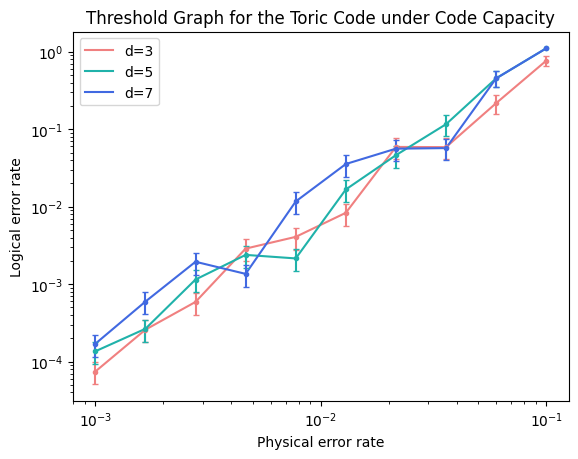

In [ ]:
# Plotting BP only

x = np.logspace(-3, -1, 10)
num_failures = {3 : 5, 5 : 5, 7 : 5}
plot_results, plot_error_bars = process_results(ldpc_results, num_failures)

plt.loglog(x, plot_results[3], color='lightcoral')
plt.loglog(x, plot_results[5], color='lightseagreen')
plt.loglog(x, plot_results[7], color='royalblue')
# plt.loglog(x[4:], plot_results[9][4:], color='gold')

plt.errorbar(x, plot_results[3], yerr=plot_error_bars[3], fmt='.', capsize=2.5, color='lightcoral')
plt.errorbar(x, plot_results[5], yerr=plot_error_bars[5], fmt='.', capsize=2.5, color='lightseagreen')
plt.errorbar(x, plot_results[7], yerr=plot_error_bars[7], fmt='.', capsize=2.5, color='royalblue')
# plt.errorbar(x[4:], plot_results[9][4:], yerr=plot_error_bars[9][4:], fmt='.', capsize=2.5, color='gold')

plt.legend(['d=3', 'd=5', 'd=7'])
plt.xlabel('Physical error rate')
plt.ylabel('Logical error rate')
plt.title('Threshold Graph for the Toric Code under Code Capacity');

## Threshold graphs for my code

In [234]:
np.logspace(-2, -0.2, 10)

array([0.01      , 0.01584893, 0.02511886, 0.03981072, 0.06309573,
       0.1       , 0.15848932, 0.25118864, 0.39810717, 0.63095734])

In [ ]:
# Code capacity model for qubit Toric code with varying distance

a = Polynomial(2, np.array([[1, 0], [1, 0]]))
b = Polynomial(2, np.array([[1, 1], [0, 0]]))

num_failures = 3
max_iter = 1000
results = {}

save_data = {}
save_data_filename = f'data_{datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")}.json'

night_debug = {}

for d in [3, 5]:
    bb = BivariateBicycle(a, b, d, d, 1)
    lx = bb.x_logicals
    # res = results_cap_qubit[d]
    res = []
    night_debug[d] = {}

    for ind, p in enumerate(np.logspace(-2, -0.2, 10)):

        night_debug[d][p] = {}

        bp_errors = 0
        osd_errors = 0

        bp_successes = 0
        osd_success = 0

        failed_osd_posteriors = []
        failed_syndromes = []

        failures = 0
        num_trials = 0
        #if d == 5:
        #    if p < 0.002:
        #        res.append(np.inf)
        #        continue
        #if d == 7:
        #    if p < 0.003:
        #        res.append(np.inf)
        #        continue
        #if d == 9:
        #    if p < 0.004:
        #        res.append(np.inf)
        #        continue
        while failures < num_failures:
            # Generate syndrome
            n_qudits = bb.hx.shape[1]
            error = np.zeros(n_qudits, dtype=int)
            error_mask = np.random.rand(n_qudits) < p
            for i in np.where(error_mask)[0]:
                error[i] = np.random.randint(1, bb.field)
            syndrome = (bb.hx @ error) % bb.field

            # Construct error probability
            channel_prob_x = np.ones(n_qudits) * p

            x_prior = np.zeros((len(channel_prob_x), 2), dtype=float)

            for i, prob in enumerate(channel_prob_x):
                x_prior[i, 0] = 1 - prob
                for j in range(1, 2):
                    x_prior[i, j] = prob / (2 - 1)

            # Decode
            guessed_error, decoder_success, bp_success, posterior = bp_osd(bb.field, bb.hx, syndrome, x_prior, max_iter, order=0, debug=True)
            error_difference = (error - guessed_error) % 2
            logical_effect = (np.array(lx) @ error_difference) % 2

            # Check success
            if np.any(logical_effect != 0):
                failures += 1
                if bp_success:
                    bp_errors += 1
                else:
                    osd_errors += 1
                    failed_osd_posteriors.append(posterior)
                    failed_syndromes.append(syndrome)
                print(f'Found {failures} / {num_failures}, with num_trials : {num_trials}')
            else:
                if bp_success:
                    bp_successes += 1
                else:
                    osd_success += 1

            if num_trials % 100 == 0:
                save_data['num_trials'] = num_trials
                save_data['failures'] = failures
                json.dump(save_data, open(save_data_filename, 'w'), indent=4)

            num_trials += 1

        night_debug[d][p]['bp_errors'] = bp_errors
        night_debug[d][p]['osd_errors'] = osd_errors
        night_debug[d][p]['bp_success'] = bp_successes
        night_debug[d][p]['osd_success'] = osd_success
        night_debug[d][p]['failed_osd_posteriors'] = failed_osd_posteriors
        night_debug[d][p]['failed_syndromes'] = failed_syndromes

        res.append(num_trials)

        print(f'Finished p={p} for d={d} with num_trials={num_trials}')

    print(f'Completed d={d}')
    results[d] = res

C:\Users\elean\Documents\Quantum-Computing-PhD\ITP\IP-BBQ\qudit-bivariate-bicycle\bbq\decoder.py:76: ComplexWarning: Casting complex values to real discards the imaginary part
  P[i, error, k] = sub_convolution[(syndrome[i] - k) % field]


Found 1 / 3, with num_trials : 315
Found 2 / 3, with num_trials : 712


KeyboardInterrupt: 

In [ ]:
night_debug[3]

{np.float64(0.01): {'bp_errors': 3,
  'osd_errors': 0,
  'bp_success': True,
  'osd_success': 6,
  'failed_osd_posteriors': []},
 np.float64(0.015848931924611134): {'bp_errors': 3,
  'osd_errors': 0,
  'bp_success': True,
  'osd_success': 7,
  'failed_osd_posteriors': []},
 np.float64(0.025118864315095794): {'bp_errors': 2,
  'osd_errors': 1,
  'bp_success': False,
  'osd_success': 10,
  'failed_osd_posteriors': [array([[7.46329780e+01, 1.33989026e-02],
          [4.85236060e+01, 2.06085261e-02],
          [1.73415687e+03, 5.76649102e-04],
          [4.85236060e+01, 2.06085261e-02],
          [7.46329780e+01, 1.33989026e-02],
          [1.73415687e+03, 5.76649102e-04],
          [1.08405659e+00, 9.22461071e-01],
          [1.08405659e+00, 9.22461071e-01],
          [1.38566902e+02, 7.21673058e-03],
          [1.73415687e+03, 5.76649102e-04],
          [1.38566902e+02, 7.21673058e-03],
          [1.73415687e+03, 5.76649102e-04],
          [4.85236060e+01, 2.06085261e-02],
          [1.0

In [244]:
results_debug_osd[3]

[1623, 521, 331, 89, 18, 7, 4, 4, 5, 5]

In [ ]:
night_debug[5]

{np.float64(0.01): {'bp_errors': 2,
  'osd_errors': 1,
  'bp_success': False,
  'osd_success': 403,
  'failed_osd_posteriors': [array([[5.40744576e+05, 1.84930195e-06],
          [2.22276900e+02, 4.49889305e-03],
          [2.22276900e+02, 4.49889305e-03],
          [5.40744576e+05, 1.84930195e-06],
          [4.62390761e+07, 2.16267297e-08],
          [8.41494443e+05, 1.18836198e-06],
          [2.21205749e+02, 4.52067816e-03],
          [8.84209883e+01, 1.13095320e-02],
          [4.47590237e+02, 2.23418636e-03],
          [2.08425231e+06, 4.79788362e-07],
          [2.17051943e+04, 4.60719211e-05],
          [2.05857276e+00, 4.85773453e-01],
          [5.31720259e-01, 1.88068817e+00],
          [4.38763701e+02, 2.27913111e-03],
          [8.63736726e+05, 1.15776019e-06],
          [4.38763701e+02, 2.27913111e-03],
          [5.31720259e-01, 1.88068817e+00],
          [2.05857276e+00, 4.85773453e-01],
          [2.17051943e+04, 4.60719211e-05],
          [8.63736726e+05, 1.15776019e-

In [245]:
results_debug_osd[5]

[28915, 3354, 932, 49, 51, 6, 8, 3, 4, 7]

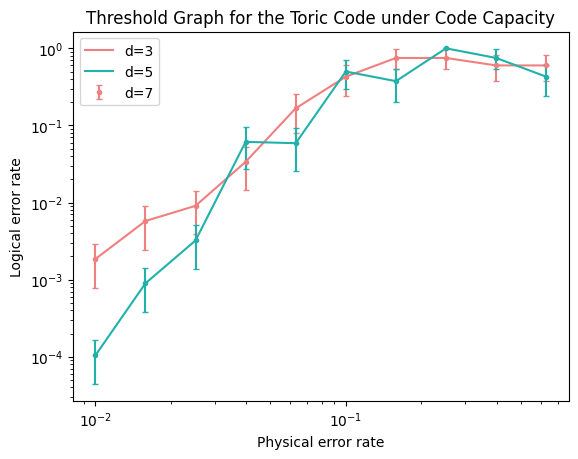

In [249]:
x = np.logspace(-2, -0.2, 10)
num_failures = {3 : 3, 5 : 3, 7 : 3}
plot_results, plot_error_bars = process_results(results_debug_osd, num_failures)

plt.loglog(x, plot_results[3], color='lightcoral')
plt.loglog(x, plot_results[5], color='lightseagreen')
# plt.loglog(x, plot_results[7], color='royalblue')
# plt.loglog(x[4:], plot_results[9][4:], color='gold')

plt.errorbar(x, plot_results[3], yerr=plot_error_bars[3], fmt='.', capsize=2.5, color='lightcoral')
plt.errorbar(x, plot_results[5], yerr=plot_error_bars[5], fmt='.', capsize=2.5, color='lightseagreen')
# plt.errorbar(x, plot_results[7], yerr=plot_error_bars[7], fmt='.', capsize=2.5, color='royalblue')
# plt.errorbar(x[4:], plot_results[9][4:], yerr=plot_error_bars[9][4:], fmt='.', capsize=2.5, color='gold')

plt.legend(['d=3', 'd=5', 'd=7'])
plt.xlabel('Physical error rate')
plt.ylabel('Logical error rate')
plt.title('Threshold Graph for the Toric Code under Code Capacity');

In [266]:
np.logspace(-1.7, -0.7, 10)

array([0.01995262, 0.0257698 , 0.03328298, 0.04298662, 0.05551936,
       0.07170601, 0.09261187, 0.11961283, 0.15448591, 0.19952623])

In [279]:
np.flip(np.logspace(-1.7, -0.7, 10))

array([0.19952623, 0.15448591, 0.11961283, 0.09261187, 0.07170601,
       0.05551936, 0.04298662, 0.03328298, 0.0257698 , 0.01995262])

In [34]:
np.flip(np.logspace(-1.7, -0.7, 10)[0:2])

array([0.0257698 , 0.01995262])

In [5]:
# Code capacity model for qubit Toric code with varying distance

a = Polynomial(2, np.array([[1, 0], [1, 0]]))
b = Polynomial(2, np.array([[1, 1], [0, 0]]))

num_failures = 5
max_iter = 1000
night_results = {}

save_data = {}
save_data_filename = f'data_{datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")}.json'

night_debug = {}

for d in [7]:
    bb = BivariateBicycle(a, b, d, d, 1)
    lx = bb.x_logicals
    # res = results[d]
    res = []
    night_debug[d] = {}

    for ind, p in enumerate(np.flip(np.logspace(-1.7, -0.7, 10)[0:2])):

        night_debug[d][p] = {}

        bp_errors = 0
        osd_errors = 0

        bp_successes = 0
        osd_success = 0

        # failed_osd_posteriors = []
        # failed_syndromes = []

        failures = 0
        num_trials = 0

        if d==7 and ind==0:
            failures = 4
            num_trials = 4059

        while failures < num_failures:
            # Generate syndrome
            n_qudits = bb.hx.shape[1]
            error = np.zeros(n_qudits, dtype=int)
            error_mask = np.random.rand(n_qudits) < p
            for i in np.where(error_mask)[0]:
                error[i] = np.random.randint(1, bb.field)
            syndrome = (bb.hx @ error) % bb.field

            # Construct error probability
            channel_prob_x = np.ones(n_qudits) * p

            x_prior = np.zeros((len(channel_prob_x), 2), dtype=float)

            for i, prob in enumerate(channel_prob_x):
                x_prior[i, 0] = 1 - prob
                for j in range(1, 2):
                    x_prior[i, j] = prob / (2 - 1)

            # Decode
            guessed_error, decoder_success, bp_success, posterior = bp_osd(bb.field, bb.hx, syndrome, x_prior, max_iter, order=0, debug=True)
            error_difference = (error - guessed_error) % 2
            logical_effect = (np.array(lx) @ error_difference) % 2

            # Check success
            if np.any(logical_effect != 0):
                failures += 1
                if bp_success:
                    bp_errors += 1
                else:
                    osd_errors += 1
                    #failed_osd_posteriors.append(posterior)
                    #failed_syndromes.append(syndrome)
                print(f'Found {failures} / {num_failures}, with num_trials : {num_trials}')
            else:
                if bp_success:
                    bp_successes += 1
                else:
                    osd_success += 1

            if num_trials % 100 == 0:
                save_data['num_trials'] = num_trials
                save_data['failures'] = failures
                json.dump(save_data, open(save_data_filename, 'w'), indent=4)

            num_trials += 1

        night_debug[d][p]['bp_errors'] = bp_errors
        night_debug[d][p]['osd_errors'] = osd_errors
        night_debug[d][p]['bp_success'] = bp_successes
        night_debug[d][p]['osd_success'] = osd_success
        #night_debug[d][p]['failed_osd_posteriors'] = failed_osd_posteriors
        #night_debug[d][p]['failed_syndromes'] = failed_syndromes

        res.append(num_trials)

        print(f'Finished p={p} for d={d} with num_trials={num_trials}')

    print(f'Completed d={d}')
    night_results[d] = res

C:\Users\elean\Documents\Quantum-Computing-PhD\ITP\IP-BBQ\qudit-bivariate-bicycle\bbq\decoder.py:76: ComplexWarning: Casting complex values to real discards the imaginary part
  P[i, error, k] = sub_convolution[(syndrome[i] - k) % field]


Found 5 / 5, with num_trials : 5182
Finished p=0.025769803745148787 for d=7 with num_trials=5183
Found 1 / 5, with num_trials : 494
Found 2 / 5, with num_trials : 4530
Found 3 / 5, with num_trials : 8425
Found 4 / 5, with num_trials : 17175
Found 5 / 5, with num_trials : 18541
Finished p=0.0199526231496888 for d=7 with num_trials=18542
Completed d=7


In [6]:
night_results

{7: [5183, 18542]}

In [8]:
results = {3: [424, 157, 87, 53, 44, 31, 17, 16, 13, 8],
 5: [6496, 1636, 951, 330, 140, 67, 12, 19, 13, 7],
 7: [18542, 5183, 2947, 544, 110, 92, 21, 14, 6, 8]}

In [9]:
results

{3: [424, 157, 87, 53, 44, 31, 17, 16, 13, 8],
 5: [6496, 1636, 951, 330, 140, 67, 12, 19, 13, 7],
 7: [18542, 5183, 2947, 544, 110, 92, 21, 14, 6, 8]}

In [10]:
jos_results = {5: [4039, 1692, 489, 204, 107, 33, 32, 22, 13, 8],
 7: [23580, 8294, 1478, 558, 145, 137, 23, 19, 7, 12],
 3: [416, 385, 213, 105, 112, 36, 22, 25, 7, 10]}

In [ ]:
debug

{3: {np.float64(0.0199526231496888): {'bp_errors': 5,
   'osd_errors': 0,
   'bp_success': True,
   'osd_success': 7,
   'failed_osd_posteriors': [],
   'failed_syndromes': []},
  np.float64(0.025769803745148787): {'bp_errors': 2,
   'osd_errors': 3,
   'bp_success': False,
   'osd_success': 3,
   'failed_osd_posteriors': [array([[4.71862362e+01, 2.11926206e-02],
           [1.63940180e+03, 6.09978592e-04],
           [7.26227462e+01, 1.37697905e-02],
           [1.08648429e+00, 9.20399870e-01],
           [1.34578776e+02, 7.43059215e-03],
           [1.08648429e+00, 9.20399870e-01],
           [7.26227462e+01, 1.37697905e-02],
           [1.63940180e+03, 6.09978592e-04],
           [4.71862362e+01, 2.11926206e-02],
           [1.08648429e+00, 9.20399870e-01],
           [4.71862362e+01, 2.11926206e-02],
           [7.26227462e+01, 1.37697905e-02],
           [1.08648429e+00, 9.20399870e-01],
           [7.26227462e+01, 1.37697905e-02],
           [4.71862362e+01, 2.11926206e-02],
    

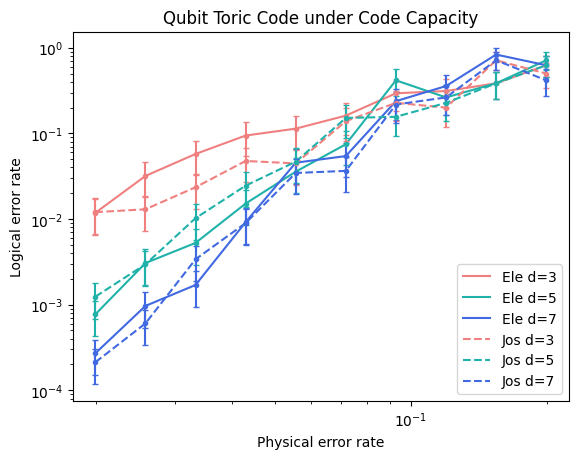

In [14]:
x = np.logspace(-1.7, -0.7, 10)
num_failures = {3 : 5, 5 : 5, 7 : 5}
plot_results, plot_error_bars = process_results(results, num_failures)
jos_plot_results, jos_plot_error_bars = process_results(jos_results, num_failures)

plt.loglog(x, plot_results[3], color='lightcoral')
plt.loglog(x, plot_results[5], color='lightseagreen')
plt.loglog(x, plot_results[7], color='royalblue')
plt.loglog(x, jos_plot_results[3], '--', color='lightcoral')
plt.loglog(x, jos_plot_results[5], '--', color='lightseagreen')
plt.loglog(x, jos_plot_results[7], '--', color='royalblue')

plt.errorbar(x, plot_results[3], yerr=plot_error_bars[3], fmt='.', capsize=2.5, color='lightcoral')
plt.errorbar(x, plot_results[5], yerr=plot_error_bars[5], fmt='.', capsize=2.5, color='lightseagreen')
plt.errorbar(x, plot_results[7], yerr=plot_error_bars[7], fmt='.', capsize=2.5, color='royalblue')
plt.errorbar(x, jos_plot_results[3], yerr=jos_plot_error_bars[3], fmt='.', capsize=2.5, color='lightcoral')
plt.errorbar(x, jos_plot_results[5], yerr=jos_plot_error_bars[5], fmt='.', capsize=2.5, color='lightseagreen')
plt.errorbar(x, jos_plot_results[7], yerr=jos_plot_error_bars[7], fmt='.', capsize=2.5, color='royalblue')

plt.legend(['Ele d=3', 'Ele d=5', 'Ele d=7', 'Jos d=3', 'Jos d=5', 'Jos d=7'])
plt.xlabel('Physical error rate')
plt.ylabel('Logical error rate')
plt.title('Qubit Toric Code under Code Capacity');